1.1 P(Churn) = 0.26578498293515357

1.2 Conditional:
Month-to-month: 0.4270967741935484
tenure < 12: 0.48542274052478135
Fiber optic: 0.4189276485788114
Electronic check: 0.4528541226215645

1.3 Joint + Lift:
Joint P = 0.5460526315789473
Lift = 2.0544901579792176

1.4 Feature comparison:
Lowest churn contract: Two year 0.028486646884272996
Senior vs Non-senior: 0.4168126094570928 0.2365025466893039
Paperless YES vs NO: 0.33589251439539347 0.16375698324022347

1.5 Top-5 features:
[('Contract', np.float64(0.23729833605088058)), ('InternetService', np.float64(0.1914428776719957)), ('OnlineSecurity', np.float64(0.1914428776719957)), ('OnlineBackup', np.float64(0.1914428776719957)), ('DeviceProtection', np.float64(0.1914428776719957))]


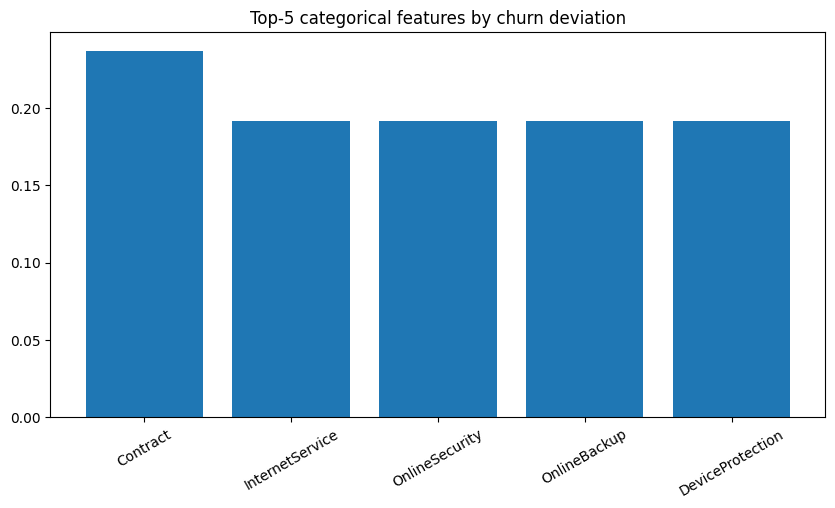

In [5]:
# =====================================================
# CUSTOMER CHURN — FULL SOLUTION (TASK 1–3)
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

DATA_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"


# =====================================================
# 0) LOAD + BASIC CLEANING
# =====================================================

df = pd.read_csv(DATA_PATH)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)
df["Churn"] = (df["Churn"] == "Yes").astype(int)


# =====================================================
# TASK 1 — EXPLORATORY PROBABILITY ANALYSIS
# =====================================================

def cond_prob(mask):
    return df.loc[mask, "Churn"].mean()


# -----------------------------
# 1.1 Overall churn probability
# -----------------------------
p_churn = df["Churn"].mean()
print("1.1 P(Churn) =", p_churn)


# -----------------------------
# 1.2 Conditional probabilities
# -----------------------------
p_m2m = cond_prob(df["Contract"] == "Month-to-month")
p_tenure_lt12 = cond_prob(df["tenure"] < 12)
p_fiber = cond_prob(df["InternetService"] == "Fiber optic")
p_echeck = cond_prob(df["PaymentMethod"] == "Electronic check")

print("\n1.2 Conditional:")
print("Month-to-month:", p_m2m)
print("tenure < 12:", p_tenure_lt12)
print("Fiber optic:", p_fiber)
print("Electronic check:", p_echeck)


# -----------------------------
# 1.3 Joint probability + lift
# -----------------------------
mask_joint = (
    (df["Contract"] == "Month-to-month") &
    (df["InternetService"] == "Fiber optic")
)

p_joint = cond_prob(mask_joint)
lift = p_joint / p_churn

print("\n1.3 Joint + Lift:")
print("Joint P =", p_joint)
print("Lift =", lift)


# -----------------------------
# 1.4 Feature comparison
# -----------------------------
contract_rates = df.groupby("Contract")["Churn"].mean().sort_values()
lowest_contract = contract_rates.index[0]
lowest_prob = contract_rates.iloc[0]

p_senior = cond_prob(df["SeniorCitizen"] == 1)
p_nonsenior = cond_prob(df["SeniorCitizen"] == 0)

p_paper_yes = cond_prob(df["PaperlessBilling"] == "Yes")
p_paper_no = cond_prob(df["PaperlessBilling"] == "No")

print("\n1.4 Feature comparison:")
print("Lowest churn contract:", lowest_contract, lowest_prob)
print("Senior vs Non-senior:", p_senior, p_nonsenior)
print("Paperless YES vs NO:", p_paper_yes, p_paper_no)


# -----------------------------
# 1.5 Top-5 predictive features
# -----------------------------
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
cat_cols = [c for c in df.columns if c not in ["customerID", "Churn"] + num_cols]

feature_scores = []

for col in cat_cols:
    rates = df.groupby(col)["Churn"].mean()
    score = (rates - p_churn).abs().max()
    feature_scores.append((col, score))

feature_scores.sort(key=lambda x: x[1], reverse=True)
top5 = [x[0] for x in feature_scores[:5]]
top5_scores = [x[1] for x in feature_scores[:5]]

print("\n1.5 Top-5 features:")
print(list(zip(top5, top5_scores)))

plt.figure(figsize=(10, 5))
plt.bar(top5, top5_scores)
plt.title("Top-5 categorical features by churn deviation")
plt.xticks(rotation=30)
plt.show()

## TASK 2

2.1 Train shape: (5625, 20) Test shape: (1407, 20)
2.1 Train churn rate: 0.2657777777777778 Test churn rate: 0.2658137882018479

2.2 Priors:
P(NoChurn) = 0.7342222222222222
P(Churn)   = 0.2657777777777778

2.3 Examples (first 5):
P(Churn) = [1.08348418e-03 9.89834696e-01 4.70531958e-08 1.15723485e-05
 1.58646128e-03]
Pred    = [0 1 0 0 0]
True    = [0 0 0 1 0]

2.4 Metrics (Scratch NB):
Accuracy : 0.7135749822316987
Precision: 0.47665056360708535
Recall   : 0.7914438502673797
F1       : 0.5949748743718593
Confusion matrix:
 [[708 325]
 [ 78 296]]


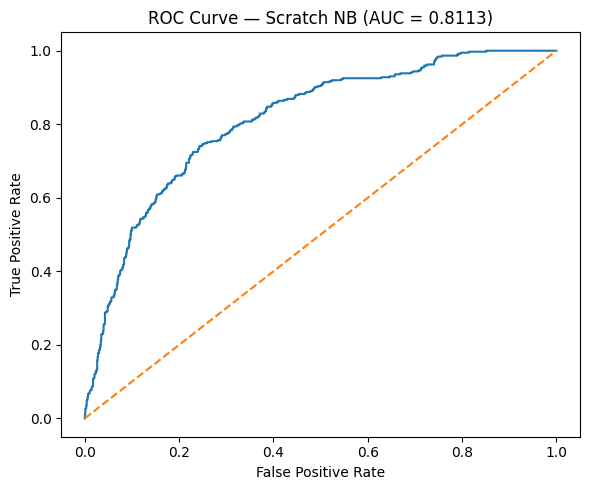

AUC = 0.811254018460328


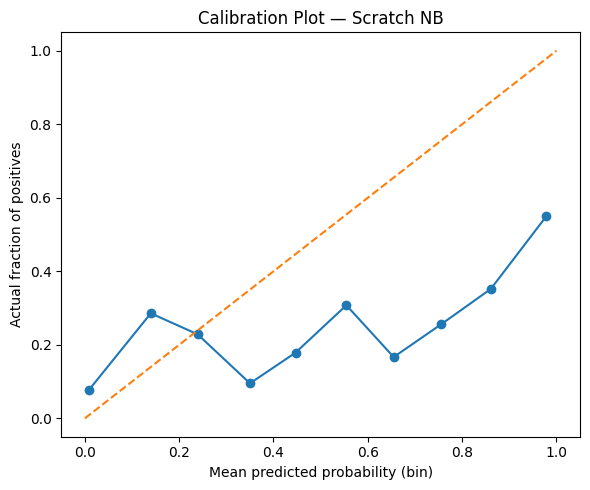


2.5 Metrics (sklearn GaussianNB):
Accuracy : 0.681592039800995
Precision: 0.44668587896253603
Recall   : 0.8288770053475936
F1       : 0.5805243445692884
Confusion matrix:
 [[649 384]
 [ 64 310]]
AUC = 0.8044543435608865


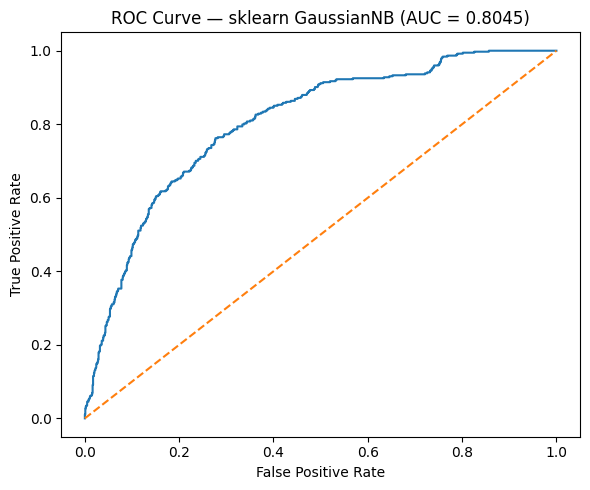

In [6]:
# =====================================================
# TASK 2 — NAIVE BAYES FROM SCRATCH
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB


# -----------------------------
# 2.1 Data split (80/20)
# -----------------------------
X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
cat_cols = [c for c in X.columns if c not in num_cols and c != "customerID"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("2.1 Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("2.1 Train churn rate:", y_train.mean(), "Test churn rate:", y_test.mean())


# -----------------------------
# 2.2 Scratch Naive Bayes
#   - Categorical: P(value | class) with Laplace smoothing
#   - Numeric: Gaussian assumption (mean/var per class)
#   - Use log-probabilities to avoid underflow
# -----------------------------
@dataclass
class ScratchNB:
    cat_cols: List[str]
    num_cols: List[str]
    alpha: float = 1.0  # Laplace smoothing

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # Priors
        self.prior = {0: (y == 0).mean(), 1: (y == 1).mean()}

        # Store log-probs for categorical likelihoods
        self.cat_logprob = {}              # (col, value, cls) -> log P
        self.cat_default_logprob = {}      # (col, cls) -> log P(unseen)

        # Store Gaussian params for numeric features
        self.gauss = {}                    # (col, cls) -> (mean, var)

        # ---- Categorical likelihoods ----
        for col in self.cat_cols:
            values = X[col].astype(str).unique()
            V = len(values)

            for cls in [0, 1]:
                Xc = X.loc[y == cls, col].astype(str)
                n = len(Xc)
                counts = Xc.value_counts()

                # Default probability for unseen values in test
                # P(unseen | cls) = alpha / (n + alpha*V)
                default_p = self.alpha / (n + self.alpha * V)
                self.cat_default_logprob[(col, cls)] = np.log(default_p)

                for v in values:
                    p = (counts.get(v, 0) + self.alpha) / (n + self.alpha * V)
                    self.cat_logprob[(col, v, cls)] = np.log(p)

        # ---- Numeric likelihoods (Gaussian) ----
        for col in self.num_cols:
            for cls in [0, 1]:
                arr = X.loc[y == cls, col].astype(float).values
                mean = arr.mean()
                var = arr.var(ddof=0)       # population variance
                var = max(var, 1e-9)        # numerical safety
                self.gauss[(col, cls)] = (mean, var)

        return self

    def _log_gauss_pdf(self, x, mean, var):
        # log N(x | mean, var)
        return -0.5 * (np.log(2*np.pi*var) + ((x-mean)**2)/var)

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        # Returns P(Churn=1) for each row
        out = np.zeros(len(X), dtype=float)

        for i, row in enumerate(X.itertuples(index=False)):
            r = row._asdict()

            logp0 = np.log(self.prior[0])
            logp1 = np.log(self.prior[1])

            # Categorical contributions
            for col in self.cat_cols:
                v = str(r[col])
                logp0 += self.cat_logprob.get((col, v, 0), self.cat_default_logprob[(col, 0)])
                logp1 += self.cat_logprob.get((col, v, 1), self.cat_default_logprob[(col, 1)])

            # Numeric contributions
            for col in self.num_cols:
                x = float(r[col])
                m0, v0 = self.gauss[(col, 0)]
                m1, v1 = self.gauss[(col, 1)]
                logp0 += self._log_gauss_pdf(x, m0, v0)
                logp1 += self._log_gauss_pdf(x, m1, v1)

            # Normalize (log-sum-exp)
            m = max(logp0, logp1)
            p0 = np.exp(logp0 - m)
            p1 = np.exp(logp1 - m)
            out[i] = p1 / (p0 + p1)

        return out

    def predict(self, X: pd.DataFrame, threshold=0.5) -> np.ndarray:
        return (self.predict_proba(X) > threshold).astype(int)


model = ScratchNB(cat_cols=cat_cols, num_cols=num_cols, alpha=1.0).fit(X_train, y_train)

print("\n2.2 Priors:")
print("P(NoChurn) =", model.prior[0])
print("P(Churn)   =", model.prior[1])


# -----------------------------
# 2.3 Prediction (show examples)
# -----------------------------
proba = model.predict_proba(X_test)
pred = model.predict(X_test)

print("\n2.3 Examples (first 5):")
print("P(Churn) =", proba[:5])
print("Pred    =", pred[:5])
print("True    =", y_test.values[:5])


# -----------------------------
# 2.4 Evaluation:
#   - accuracy, precision, recall, F1
#   - confusion matrix
#   - ROC + AUC
#   - calibration plot
# -----------------------------
acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred, zero_division=0)
rec = recall_score(y_test, pred, zero_division=0)
f1 = f1_score(y_test, pred, zero_division=0)
cm = confusion_matrix(y_test, pred)

print("\n2.4 Metrics (Scratch NB):")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("Confusion matrix:\n", cm)

# ROC + AUC
fpr, tpr, _ = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.title(f"ROC Curve — Scratch NB (AUC = {auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

print("AUC =", auc)

# Calibration plot (manual binning)
def calibration_curve_manual(y_true, y_prob, n_bins=10):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(y_prob, bins) - 1
    idx = np.clip(idx, 0, n_bins - 1)

    mean_pred, frac_pos = [], []
    for b in range(n_bins):
        mask = idx == b
        if mask.sum() == 0:
            continue
        mean_pred.append(y_prob[mask].mean())
        frac_pos.append(y_true[mask].mean())

    return np.array(mean_pred), np.array(frac_pos)

mean_pred, frac_pos = calibration_curve_manual(y_test.values, proba, n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0, 1], [0, 1], "--")
plt.title("Calibration Plot — Scratch NB")
plt.xlabel("Mean predicted probability (bin)")
plt.ylabel("Actual fraction of positives")
plt.tight_layout()
plt.show()


# -----------------------------
# 2.5 sklearn comparison:
#   - OneHotEncoder for categorical
#   - GaussianNB
#   - same metrics + ROC/AUC
# -----------------------------
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", "passthrough", num_cols),
])

sk_model = Pipeline([
    ("prep", preprocess),
    ("nb", GaussianNB()),
])

sk_model.fit(X_train, y_train)

sk_pred = sk_model.predict(X_test)
sk_proba = sk_model.predict_proba(X_test)[:, 1]

sk_acc = accuracy_score(y_test, sk_pred)
sk_prec = precision_score(y_test, sk_pred, zero_division=0)
sk_rec = recall_score(y_test, sk_pred, zero_division=0)
sk_f1 = f1_score(y_test, sk_pred, zero_division=0)
sk_cm = confusion_matrix(y_test, sk_pred)
sk_auc = roc_auc_score(y_test, sk_proba)

print("\n2.5 Metrics (sklearn GaussianNB):")
print("Accuracy :", sk_acc)
print("Precision:", sk_prec)
print("Recall   :", sk_rec)
print("F1       :", sk_f1)
print("Confusion matrix:\n", sk_cm)
print("AUC =", sk_auc)

fpr2, tpr2, _ = roc_curve(y_test, sk_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr2, tpr2)
plt.plot([0, 1], [0, 1], "--")
plt.title(f"ROC Curve — sklearn GaussianNB (AUC = {sk_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

In [7]:
# =====================================================
# TASK 3 — BUSINESS DECISION ANALYSIS
# =====================================================

import numpy as np
import pandas as pd

# Assumes you already have:
# - df (cleaned, with Churn as 0/1)
# - ScratchNB class defined (from Task 2)
# If not, run Task 2 first.

# -----------------------------
# 3.0 Train scratch NB on FULL data + score p_churn
# -----------------------------
X_all = df.drop(columns=["Churn"])
y_all = df["Churn"].astype(int)

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
cat_cols = [c for c in X_all.columns if c not in num_cols and c != "customerID"]

model_full = ScratchNB(cat_cols=cat_cols, num_cols=num_cols, alpha=1.0).fit(X_all, y_all)

df["p_churn"] = model_full.predict_proba(X_all)

print("3.0 p_churn summary:")
print(df["p_churn"].describe())


# =====================================================
# Scenario constants
# =====================================================
CLV = 2000
COST = 300
SUCCESS = 0.4


# -----------------------------
# 3.1 Expected value of targeting an individual
# 3.1a) Max amount to spend if p(Churn)=0.8
# 3.1b) Expected profit targeting all customers with p_churn > 0.5
# -----------------------------

p = 0.8
max_spend = p * CLV * SUCCESS
ev_individual = p * CLV * SUCCESS - COST

print("\n3.1a Individual:")
print("Max spend (break-even) for p=0.8 =", max_spend)
print("EV if cost=300 for p=0.8 =", ev_individual)

# Target rule: p_churn > 0.5
df["EV"] = df["p_churn"] * CLV * SUCCESS - COST

target_mask = df["p_churn"] > 0.5
n_target = int(target_mask.sum())
total_ev = float(df.loc[target_mask, "EV"].sum())

print("\n3.1b Target all with p_churn > 0.5:")
print("Customers targeted:", n_target)
print("Total expected profit:", total_ev)


# -----------------------------
# 3.2 Risk segmentation matrix (2x2)
# Define:
#   High Value: MonthlyCharges > 70
#   High Risk:  p_churn > 0.6
# For each quadrant report:
#   - # customers
#   - expected churn loss without intervention = sum(p_churn * CLV)
#   - expected net gain with campaign = sum(p_churn * CLV * SUCCESS - COST)
#   - ROI = net_gain / spend
# -----------------------------

high_value = df["MonthlyCharges"] > 70
high_risk = df["p_churn"] > 0.6

def segment_stats(mask: pd.Series, name: str) -> dict:
    n = int(mask.sum())

    expected_loss = float((df.loc[mask, "p_churn"] * CLV).sum())
    expected_net_gain = float((df.loc[mask, "p_churn"] * CLV * SUCCESS - COST).sum())

    spend = COST * n
    roi = expected_net_gain / spend if spend > 0 else np.nan

    return {
        "segment": name,
        "customers": n,
        "expected_churn_loss_no_campaign": expected_loss,
        "expected_net_gain_with_campaign": expected_net_gain,
        "spend_if_target_all": spend,
        "roi_net_gain_per_$spent": roi
    }

segments = [
    segment_stats(high_value & high_risk, "High Value / High Risk"),
    segment_stats(high_value & (~high_risk), "High Value / Low Risk"),
    segment_stats((~high_value) & high_risk, "Low Value / High Risk"),
    segment_stats((~high_value) & (~high_risk), "Low Value / Low Risk"),
]

seg_df = pd.DataFrame(segments).sort_values("roi_net_gain_per_$spent", ascending=False)

print("\n3.2 Segmentation matrix (sorted by ROI):")
display(seg_df)

best_segment = seg_df.iloc[0]["segment"]
print("Best ROI segment:", best_segment)


# -----------------------------
# 3.3 Budget optimization
# Budget = 50,000
# Strategy:
#   EV_i = p_churn * CLV * SUCCESS - COST
#   Sort by EV_i desc, pick top until budget exhausted
# Report:
#   - # customers targeted
#   - total expected profit
#   - % of high risk segment covered (p_churn > 0.6)
# -----------------------------

BUDGET = 50_000

# Only target positive-EV customers
candidates = df[df["EV"] > 0].copy().sort_values("EV", ascending=False)

max_customers = BUDGET // COST
selected = candidates.head(int(max_customers)).copy()

n_selected = int(len(selected))
total_expected_profit = float(selected["EV"].sum())

high_risk_total = int((df["p_churn"] > 0.6).sum())
high_risk_selected = int((selected["p_churn"] > 0.6).sum())
coverage = (high_risk_selected / high_risk_total) if high_risk_total > 0 else np.nan

print("\n3.3 Budget optimization:")
print("Budget:", BUDGET)
print("Cost per customer:", COST)
print("Customers targeted:", n_selected)
print("Total expected profit:", total_expected_profit)
print("High-risk coverage:", coverage)


# -----------------------------
# 3.4 Sensitivity analysis
# Scenarios:
#   A) Success rate drops to 20%
#   B) Retention cost rises to $500
#   C) Average CLV is $1,500
# For each:
#   - recompute optimal targeting with same budget
#   - report if campaign is worth it + how targeting changes
# -----------------------------

def optimize_strategy(success_rate, cost_per_customer, clv, budget=50_000):
    ev = df["p_churn"] * clv * success_rate - cost_per_customer
    candidates = df[ev > 0].copy()
    candidates["EV_scenario"] = ev[ev > 0]
    candidates = candidates.sort_values("EV_scenario", ascending=False)

    max_customers = budget // cost_per_customer
    selected = candidates.head(int(max_customers))

    total_profit = float(selected["EV_scenario"].sum())
    n = int(len(selected))

    high_risk_total = int((df["p_churn"] > 0.6).sum())
    high_risk_selected = int((selected["p_churn"] > 0.6).sum())
    coverage = (high_risk_selected / high_risk_total) if high_risk_total > 0 else np.nan

    return {
        "success_rate": success_rate,
        "cost": cost_per_customer,
        "CLV": clv,
        "customers_targeted": n,
        "total_expected_profit": total_profit,
        "high_risk_coverage": coverage,
        "should_run_campaign": (total_profit > 0)
    }

scenarios = [
    optimize_strategy(success_rate=0.2, cost_per_customer=300, clv=2000, budget=BUDGET),
    optimize_strategy(success_rate=0.4, cost_per_customer=500, clv=2000, budget=BUDGET),
    optimize_strategy(success_rate=0.4, cost_per_customer=300, clv=1500, budget=BUDGET),
]

sens_df = pd.DataFrame(scenarios)

print("\n3.4 Sensitivity analysis:")
display(sens_df)

3.0 p_churn summary:
count    7.032000e+03
mean     4.238856e-01
std      4.416628e-01
min      1.630739e-09
25%      7.542126e-05
50%      1.782136e-01
75%      9.557725e-01
max      9.996298e-01
Name: p_churn, dtype: float64

3.1a Individual:
Max spend (break-even) for p=0.8 = 640.0
EV if cost=300 for p=0.8 = 340.0

3.1b Target all with p_churn > 0.5:
Customers targeted: 3059
Total expected profit: 1308254.3944695403

3.2 Segmentation matrix (sorted by ROI):


,segment,customers,expected_churn_loss_no_campaign,expected_net_gain_with_campaign,spend_if_target_all,roi_net_gain_per_$spent
0,High Value / High Risk,1896,3.577277e+06,862110.865351,568800,1.515666
2,Low Value / High Risk,1025,1.835835e+06,426834.139099,307500,1.388079
1,High Value / Low Risk,1685,2.978833e+05,-386346.684049,505500,-0.764286
3,Low Value / Low Risk,2426,2.505306e+05,-627587.745154,727800,-0.862308


Best ROI segment: High Value / High Risk

3.3 Budget optimization:
Budget: 50000
Cost per customer: 300
Customers targeted: 166
Total expected profit: 82904.07165004907
High-risk coverage: 0.05682985279014036

3.4 Sensitivity analysis:


,success_rate,cost,CLV,customers_targeted,total_expected_profit,high_risk_coverage,should_run_campaign
0,0.2,300,2000,166,16552.035825,0.056830,True
1,0.4,500,2000,100,29954.659983,0.034235,True
2,0.4,300,1500,166,49728.053738,0.056830,True
